In [1]:
from rl.markov_process import (
    MarkovProcess,
    FiniteMarkovRewardProcess,
    NonTerminal,
    State,
    Terminal,
)

from rl.distribution import Categorical, Constant, FiniteDistribution


import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint

import pandas as pd

from dataclasses import dataclass

from typing import Dict, List, Mapping, Optional, Tuple, Union


In [2]:
@dataclass
class SnakesLadders_Board:
    """Class storing the positions of snakes and ladders on board"""

    tile_array: np.ndarray

    @property
    def terminal_tile_idx(self):
        return len(self.tile_array) - 1

    def __len__(self):
        return len(self.tile_array)

    @classmethod
    def generate_snakes_ladders(
        cls,
        boardsize: int,
        num_snakes: int,
        num_ladders: int,
    ) -> "SnakesLadders_Board":
        """Randomly generate positions of a given number of snakes and ladders."""
        unoccupied_spots = np.ones(shape=(boardsize), dtype=bool)
        tile_array = np.arange(boardsize)
        snake_counter, ladder_counter = 0, 0

        while snake_counter < num_snakes or ladder_counter < num_ladders:
            i = randint(1, boardsize - 1)
            while unoccupied_spots[i]:

                if snake_counter < num_snakes and i > 2:
                    snake_tail = randint(1, i)
                    if unoccupied_spots[snake_tail]:
                        tile_array[i] = snake_tail
                        unoccupied_spots[i] = False
                        unoccupied_spots[snake_tail] = False
                        snake_counter += 1

                elif ladder_counter < num_ladders and i < 99:
                    ladder_head = randint(i, boardsize)
                    if unoccupied_spots[ladder_head]:
                        tile_array[i] = ladder_head
                        unoccupied_spots[i] = False
                        unoccupied_spots[ladder_head] = False
                        ladder_counter += 1

        return SnakesLadders_Board(tile_array)


@dataclass
class SnakesLadders_State(int):
    tile_number: int

    def __hash__(self):
        return super().__hash__()


class SnakesLadders_Mapping(dict):
    state_map: Dict[State, float] = {}

    def add_state(self, state: SnakesLadders_State, prob: float) -> None:
        if state in self.state_map.keys():
            self.state_map[state] += prob
        else:
            self.state_map[state] = prob


@dataclass
class SnakesLadders_Position(MarkovProcess[SnakesLadders_State]):
    die_choices: List[int]
    board: SnakesLadders_Board

    def transition(
        self, state: NonTerminal[SnakesLadders_State], die_sides: int
    ) -> Categorical[State[SnakesLadders_State]]:
        state_mapping = SnakesLadders_Mapping()
        for roll in range(1, die_sides + 1):
            if state.tile_number + roll < self.board.terminal_tile_idx:
                state_mapping.add_state(
                    NonTerminal(
                        
                            SnakesLadders_State(
                                self.board.tile_array[state.tile_number + roll]
                            )
                        ),
                        1 / die_sides
                    
                )
            else:
                state_mapping.add_state(
                    Terminal(SnakesLadders_State(self.board.terminal_tile_idx))
                )

        return Categorical(state_mapping.state_map)


In [3]:
board = SnakesLadders_Board.generate_snakes_ladders(boardsize=100, num_ladders=10, num_snakes=10)
board

SnakesLadders_Board(tile_array=array([ 0,  1, 33,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1, 24,  7,  6,
       17, 17, 19, 20, 21,  3, 23, 24, 54, 21, 27, 27, 29, 30, 31, 32, 33,
        9, 35, 36, 72, 38, 39, 40, 31, 73, 43, 44, 45, 46, 47, 48, 97, 50,
       51, 52, 53, 54, 55, 60, 57, 58, 59, 60, 61, 62, 63, 64, 65, 88, 67,
       68, 69, 98, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 61, 92, 93, 94, 95, 96, 97, 98, 99]))

In [4]:
init_state = SnakesLadders_State(0)

pos = SnakesLadders_Position(die_choices=[6], board=board).transition(init_state, 6)

In [5]:
class SnakesLaddersMRPFinite(FiniteMarkovRewardProcess[SnakesLadders_State]):

    def __init__(self, board: SnakesLadders_Board, die_sides: int):
        self.board = board
        self.die_sides = die_sides
        super().__init__(self.get_transition_reward_map())

    def get_transition_reward_map(self) -> Mapping[SnakesLadders_State, FiniteDistribution[Tuple[SnakesLadders_State, Tuple]]]:
        d: Dict[SnakesLadders_State, Categorical[Tuple[SnakesLadders_State, float]]] = {}
        reward = 1.0
        for tile_idx in np.arange(len(self.board) - 1):
            if tile_idx == self.board.tile_array[tile_idx]:
                state = SnakesLadders_State(tile_idx)
                sr_probs_map: Dict[Tuple[SnakesLadders_State, float], float] = {}
                for roll in np.arange(1, self.die_sides + 1):
                    next_state: SnakesLadders_State
                    if state.tile_number + roll < self.board.terminal_tile_idx:
                        next_state = SnakesLadders_State(self.board.tile_array[state.tile_number + roll])
                    else:
                        next_state = SnakesLadders_State(self.board.terminal_tile_idx)
                    
                    if (next_state, reward) in sr_probs_map.keys():
                        sr_probs_map[(next_state, reward)] += 1/self.die_sides
                    else:
                        sr_probs_map[(next_state, reward)] = 1/self.die_sides
                d[state] = Categorical(sr_probs_map)
        return d

In [6]:
mrp = SnakesLaddersMRPFinite(board = board, die_sides = 6)
mrp.get_value_function_vec(gamma = 1.0)

array([25.34822095, 25.4138936 , 26.63773947, 26.40613066, 26.14724483,
       25.87360213, 25.80792948, 24.71790606, 24.87362369, 25.01647775,
       24.59392984, 24.23174592, 22.05864239, 19.91348012, 19.87199897,
       19.62311205, 18.24688132, 18.17776556, 18.12979056, 18.49744584,
       17.76307099, 16.65700606, 16.12071486, 15.61071503, 13.95954443,
       13.35682186, 12.9029677 , 12.55071604, 12.26913845,  9.96574807,
       10.23471113, 10.43720607, 10.57967291, 10.67001831, 10.70621331,
       11.84848951, 11.65217574, 11.43447393, 11.21209068, 10.92338334,
       10.67767402, 10.47429313, 10.12826305,  9.87779117,  9.19113934,
        9.20341809,  9.21771751,  9.22742964,  8.05208255,  8.37495988,
        9.27709054,  9.30351408,  9.28570243, 10.31222382, 10.02061647,
        9.74048645,  9.46205529,  9.17883254,  8.88692187,  8.5844303 ,
        8.27097239,  8.05970629,  7.79146834,  7.47949608,  7.13545784,
        6.76948087,  6.39022493,  6.79210967,  6.18204063,  5.60

In [7]:
mrp.get_transition_matrix()[:,65]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [8]:
mrp.transition(NonTerminal(SnakesLadders_State(0)))

{NonTerminal(state=SnakesLadders_State(tile_number=1)): 0.16666666666666669, NonTerminal(state=SnakesLadders_State(tile_number=33)): 0.16666666666666669, NonTerminal(state=SnakesLadders_State(tile_number=3)): 0.16666666666666669, NonTerminal(state=SnakesLadders_State(tile_number=4)): 0.16666666666666669, NonTerminal(state=SnakesLadders_State(tile_number=5)): 0.16666666666666669, NonTerminal(state=SnakesLadders_State(tile_number=6)): 0.16666666666666669}

In [9]:
init_state = NonTerminal(SnakesLadders_State(0))
init_dist = Constant(init_state)

Text(0.5, 0, 'roll number')

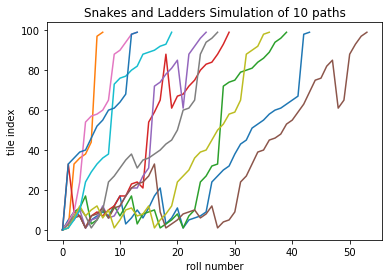

In [10]:
total_num_paths = 10

path_num = 0
for trace in mrp.traces(init_dist):
    plt.plot([sim_state.state.tile_number for sim_state in trace])
    path_num += 1
    if path_num > total_num_paths:
        break
plt.title(f"Snakes and Ladders Simulation of {total_num_paths} paths")
plt.ylabel("tile index")
plt.xlabel("roll number")

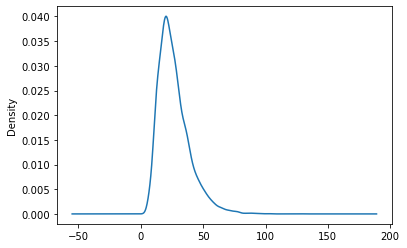

In [11]:
x = 0
rolls = []
while x < 10_000:
    n_rolls = 0
    for state in mrp.simulate(init_dist):
        n_rolls += 1
    x += 1
    rolls.append(n_rolls)

pd.Series(rolls).plot(kind='density')

In [12]:
isinstance(init_state, NonTerminal)

True

In [13]:
# state space: indexed tiles \subseteq \{0, ..., 99}, for which |S| = 100 - num_ladders - num_snakes